In [2]:
from keras.models import load_model
model = load_model('../saved_models/01052019-092342-e1.h5')

In [3]:
import pandas as pd
import numpy as np
import os

def timeDelay(df, delay):
    X_data, y_data = [], []
    
    for i in range(delay, len(df)):
        X_data.append(df[i-delay: i].tolist())
    X_data = np.array(X_data)
    y_data = df[delay:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)),\
           np.reshape(y_data, (len(y_data), ))

def split(X, y, ratio):    
    test_split = int(len(X) * ratio)
    
    X_train, y_train = X[:test_split], y[:test_split]
    X_test, y_test = X[test_split:], y[test_split:]
    return X_train, y_train, X_test, y_test

# train-test split on processed dataset
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
PROCESSED_PATH = 'data/processed'

df = pd.read_csv(os.path.join(PROJ_ROOT, PROCESSED_PATH, 'single_device_activation.csv'),
                header=0, sep=',')

X, y = timeDelay(df.Active.values, delay=5)
X_train, y_train, X_test, y_test = split(X, y, ratio=0.8)

In [44]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

KeyboardInterrupt: 

In [5]:
import math

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.01 MSE (0.08 RMSE)
Test Score: 0.00 MSE (0.00 RMSE)


In [8]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

In [68]:
import matplotlib.pyplot as plt

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, 'b--', label='True Data')
    plt.plot(predicted_data, 'r^', label='Prediction')
    plt.legend()
plt.show()

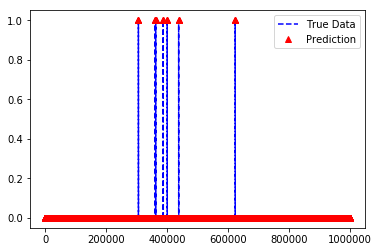

In [69]:
plot_results(y_test_pred[:1000000], y_test[:1000000])

In [45]:
y_test_pred

array([[2.8398631e-06],
       [2.8398631e-06],
       [2.8398631e-06],
       ...,
       [2.8398631e-06],
       [2.8398633e-06],
       [2.8398633e-06]], dtype=float32)

In [46]:
y_test_pred = np.reshape(y_test_pred, (y_test_pred.size,))

In [47]:
y_test_pred

array([2.8398631e-06, 2.8398631e-06, 2.8398631e-06, ..., 2.8398631e-06,
       2.8398633e-06, 2.8398633e-06], dtype=float32)

In [49]:
y_train

array([0., 0., 0., ..., 0., 0., 0.])

In [62]:
unique, counts = np.unique(y_test_pred, return_counts=True)

np.asarray((unique, counts)).T

array([[0.000000e+00, 5.824484e+06],
       [1.000000e+00, 1.000000e+02]])

In [55]:
unique, counts = np.unique(y_test, return_counts=True)

np.asarray((unique, counts)).T

array([[0.000000e+00, 5.824563e+06],
       [1.000000e+00, 2.100000e+01]])

In [56]:
y_test_pred[y_test_pred==2.83986310e-06]=0

In [57]:
y_test_pred[y_test_pred==2.83986333e-06]=0

In [58]:
y_test_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [61]:
y_test_pred[y_test_pred!=0]=1